# CDDP Tutorial (HCW)

This tutorial runs a simple example of the constrained differential dynamic programming algorithm on spacecraft linear relative motion control problem.

In [ ]:
# If needed, run the following lines:
using Pkg
Pkg.precompile()

In [13]:
using Plots; gr(legend=true,dpi=800); 
using LinearAlgebra
using BenchmarkTools
using Printf
using Revise
using CDDP

## Define the Dynamics Model

In [14]:
includet("../src/models/hcw.jl")
model = HCW()
x_dim, u_dim = model.x_dim, model.u_dim
;

## Define Problem Horizon and Steps

In [15]:
tf = 5000.0
tN = 500
dt = (tf - 0.0)/tN;

## Define the Cost Function

In [16]:
function ell_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    Q = zeros(6, 6)
    R = Diagonal(1e+2*[1; 1; 1])
    return 0.5 * transpose(x - x_ref) * Q * (x - x_ref) + 0.5 * transpose(u) * R * u
end

function phi_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+1 * [1; 1; 1]])
    return 0.5 * transpose(x - x_final) * Qf * (x - x_final)
end
;

## Define the boundary conditions

In [17]:
x_init = model.x_init
x_final = model.x_final;

Initial trajectory

In [18]:
X0, U0 = initialize_trajectory(model);

## Construct the Problem

In [19]:
prob = iLQRProblem(model, tf, tN, dt, x_dim, u_dim, ell_cost, phi_cost, model.f!, empty, x_init, x_final, nothing);

## Solve iLQR Problem

In [20]:
sol = solve_ilqr(prob)
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start iLQR Problem Solver 
**************************************************************************************
iter    objective 
                
0       20.297458,  
                


[[1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.

 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0

 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0

 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342

 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0

 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342

 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0

 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0

 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 

[1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0

 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0

 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0

; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.007394568947

 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0

 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0]]
1       0.021854,  
                


[[1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.

 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0

], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 

 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0

 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0

 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 

 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.0

], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 

 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0

 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0

 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.002464856315

; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.007394568947

 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.0073

 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 

 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.002464856315

 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 

 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.02220295618

 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303

; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202

 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.002464856315

 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.00

 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.00246485631594447

; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.002464

 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0

 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0

 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0

; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.007394568947

; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.

 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0;

 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303

; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.002464

 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.00

[[1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.

 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.002464856315

 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.00

 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 

 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.02220295618

; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303

 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.02220295618

; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.007394568947

 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.0073

 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.00246485631594447

 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303

 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.02220295618

; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202

 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0

 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342

[[1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.

 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0

 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0;

 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.02220295618

 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.02220295618

 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 

Excessive output truncated after 524300 bytes.

 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0 0.022202956181303756 0.0; -0.0 -0.0 -0.0 -0.022202956181303756 1.0 -0.0; -0.0 -0.0 -0.0024648563159444734 -0.0 -0.0 1.0], [1.0 0.0 0.0 0.05 0.0 0.0; 0.0 1.0 0.0 0.0 0.05 0.0; 0.0 0.0 1.0 0.0 0.0 0.05; 0.00739456894783342 0.0 0.0 1.0

## Plot Trajectory

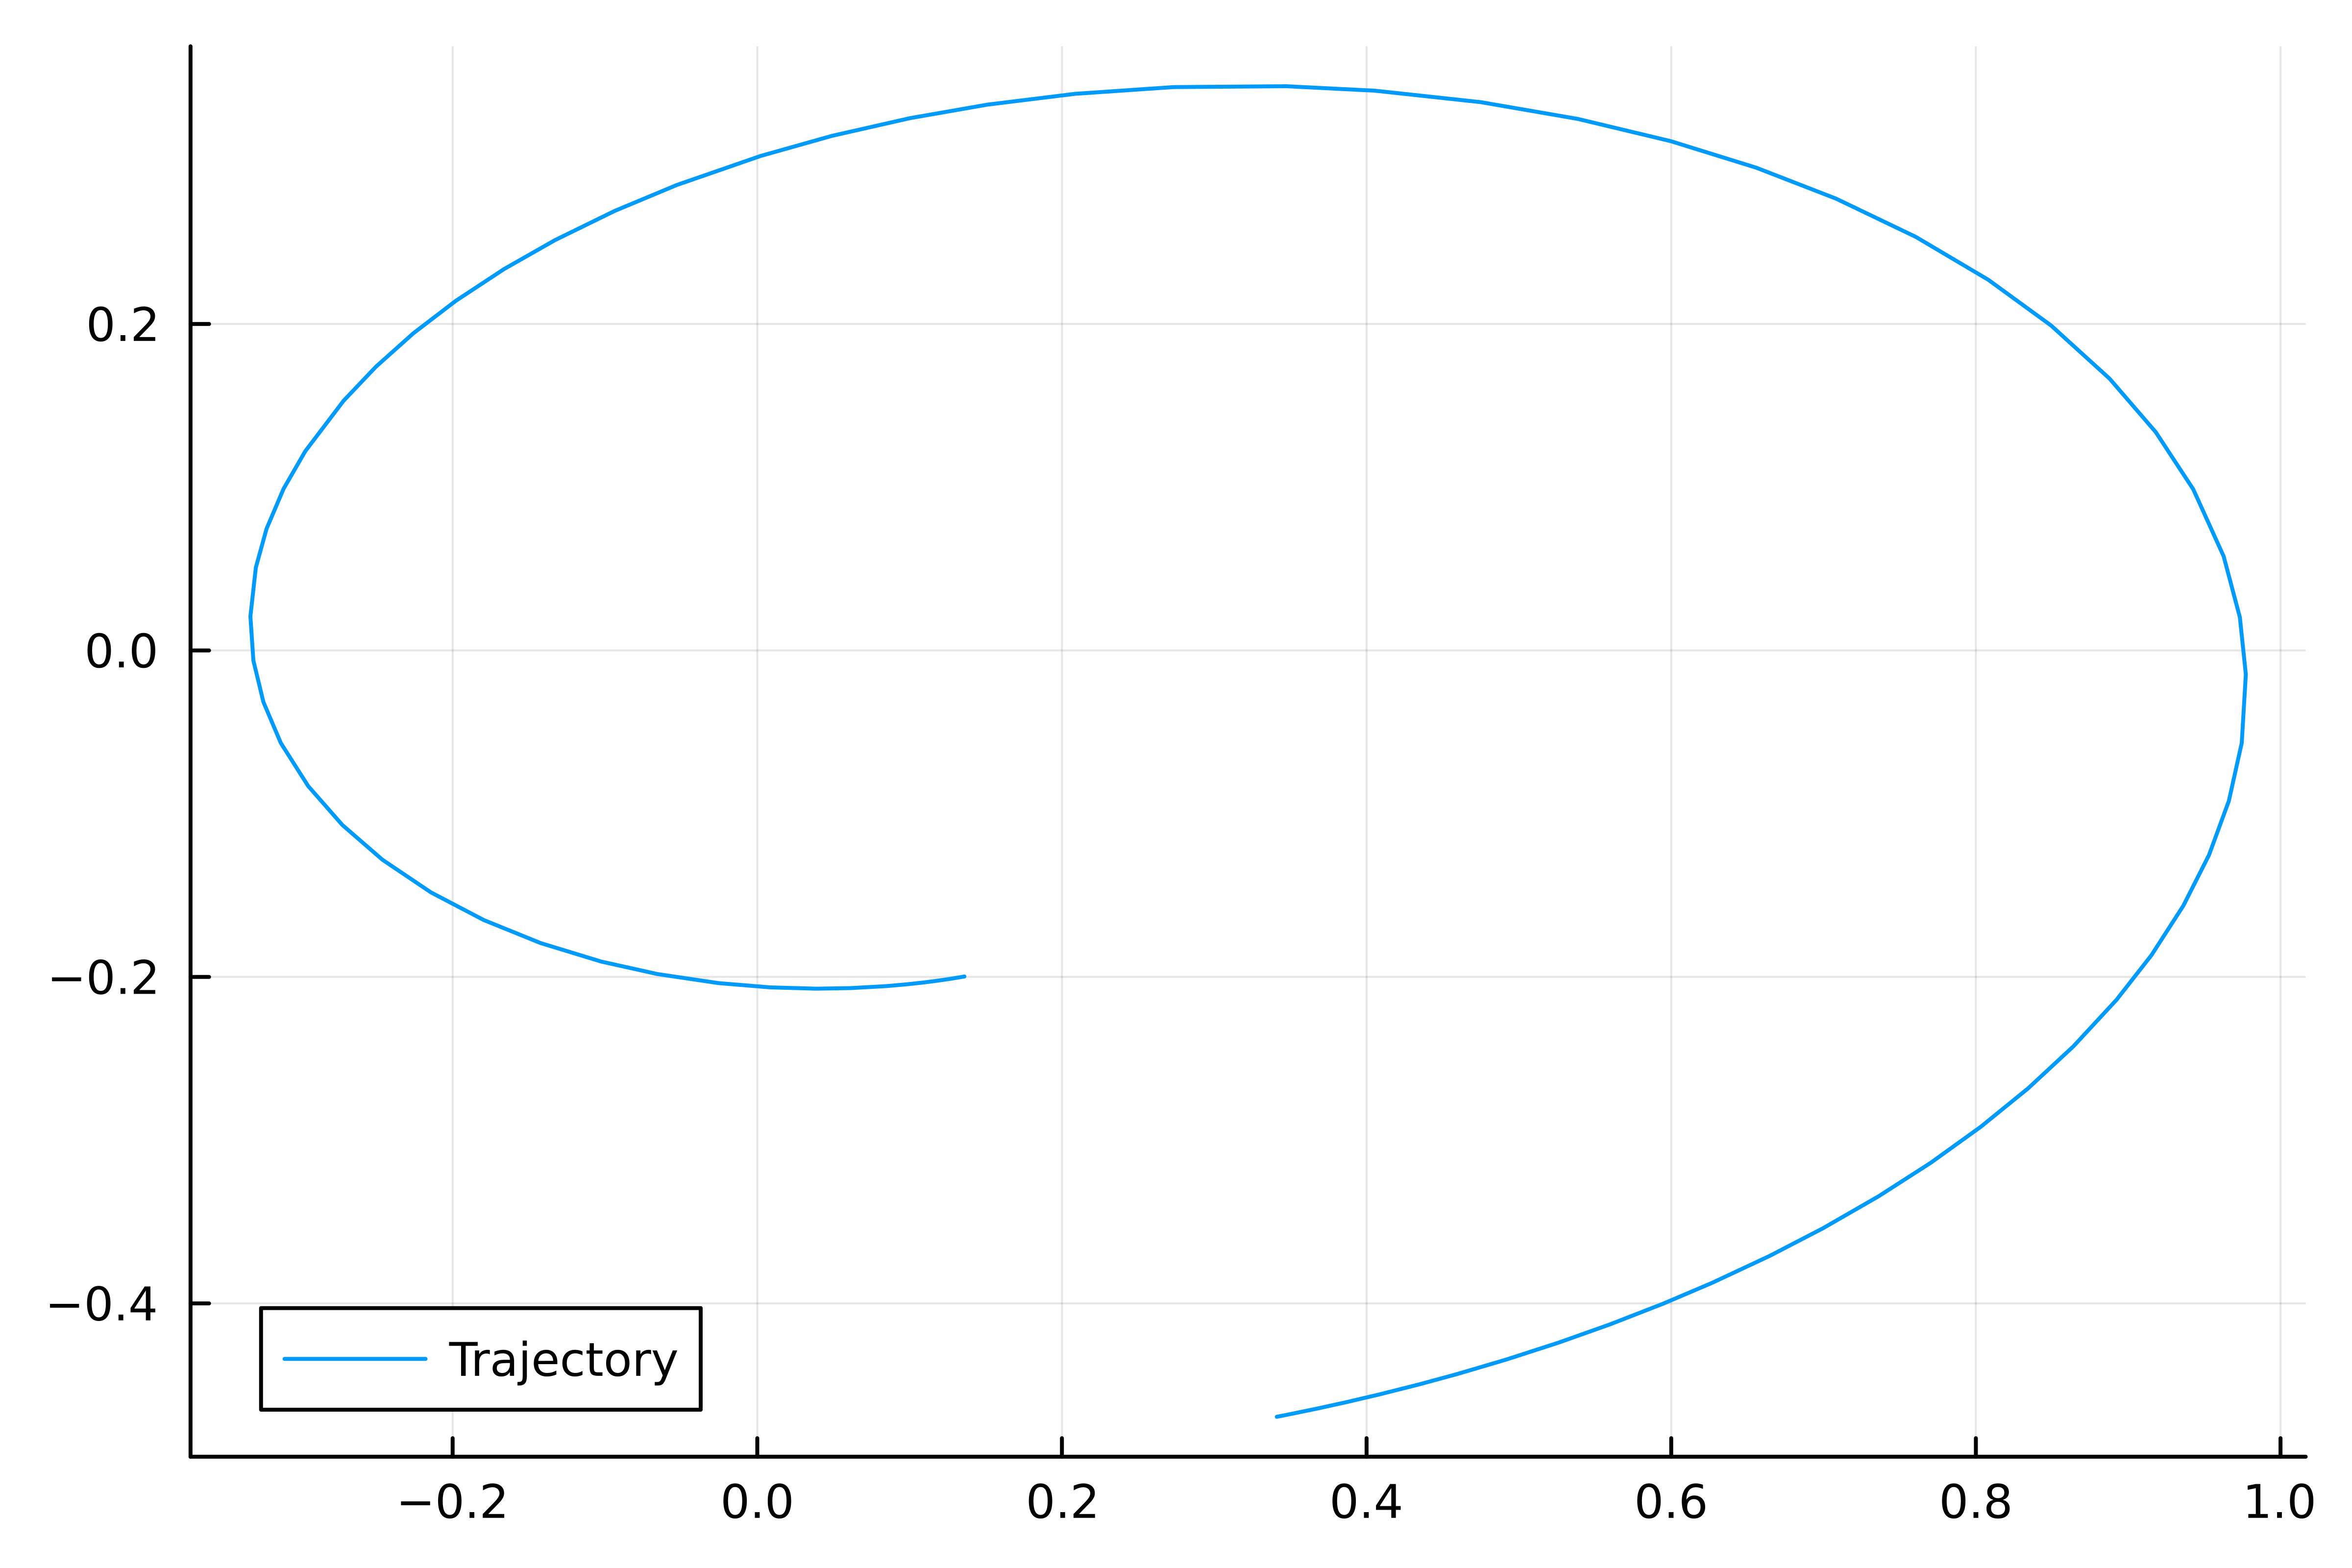

In [12]:
plot(X[2,:],X[1,:],label="Trajectory")

In [122]:
function c(
    x::Vector,
    u::Vector,
)
    x0 = [45; 135]
    r_scale = 200

    return [
        1e-0 * (20 / r_scale - norm(x[1:2] - x0 / r_scale))
        1e-0 * (10 / r_scale - norm(x[1:2]))
    ]
end
λ_dim = 2

2

In [132]:
prob = CDDPProblem(model, tf, tN, dt, x_dim, u_dim, λ_dim, ell_cost, phi_cost, model.f!, x_init, x_final, c, empty, nothing);
# sol = solve_cddp(prob,reg_param1=1e-2,reg_param2=1e-2,μip=1e-10, max_ite=10, verbose=true) 
# sol = solve_cddp(prob, X=X_ilqr, U=U_ilqr,max_ite=20); 
sol = solve_cddp(prob, X=X_ilqr, U=U_ilqr, reg_param1=1e-4,reg_param2=1e-4,μip=1e-8,max_ite=10); 
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_cddp, U_cddp, J_cddp, gains_cddp = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start CDDP Problem Solver 
**************************************************************************************
isfeasible: false
iter    objective   inf_pr     inf_du   lg(mu)   |d|   lg(rg)  alpha_du   alpha_pr   ls
                
0       Inf,  
                


isfeasible_new: true isfeasible: falsey[[-2.3219672396398607, -1.674504910662535], [-2.291276540547364, -1.6978260577419302], [-2.2608960275383305, -1.721505498352228], [-2.230829996494469, -1.7455220233147333], [-2.2010825338768, -1.7698544710665975], [-2.1716575013524646, -1.7944815258064615], [-2.1425585178307784, -1.8193812965399692], [-2.113788941808492, -1.8445304703180894], [-2.085351867319731, -1.8699026254616598], [-2.057250172699636, -1.8954648937840466], [-2.0294867288596006, -1.9211713631036749], [-2.0020650286601667, -1.94695006977569], [-1.974990881718705, -1.972677335446061], [-1.9482766742030944, -1.9981271710195851], [-1.9219516535572723, -2.02287152612838], [-1.8960860741493617, -2.046083646424525], [-1.870846740042045, -2.0661504348776747], [-1.8466227965094757, -2.079908339726067], [-1.8243071327992153, -2.0811371889353336], [-1.8059196373269688, -2.0575914268680715], [-1.7959762236318266, -1.985148627332889], [-1.8044751050626557, -1.8162764203040964], [-1.85337210

, [4.716221006642574e60, 7.6132758203393335e59], [9.532922224087833e60, 1.5906110345612056e60], [1.9273620730416745e61, 3.323170438522012e60], [3.89764876303086e61, 6.942844321817036e60], [7.883902476813712e61, 1.450502290365912e61], [1.5950569362699158e62, 3.03036947451026e61], [3.2277880598018644e62, 6.330950245083059e61], [6.533191445711285e62, 1.3226299039753827e62], [1.322620312131556e63, 2.7631460377573073e62], [2.6781351100501596e63, 5.772518323989516e62], [5.42394788834565e63, 1.2059315622991626e63], [1.0987089676525023e64, 2.5192757307886626e63], [2.2260377738001616e64, 5.262889297745817e63], [4.510906274794363e64, 1.0994310445610902e64], [9.142718504826805e64, 2.2967126664291794e64], [1.8533871924662523e65, 4.797774828737808e64], [3.757814643511347e65, 1.0022293880557029e65], [7.620477533208116e65, 2.0935722621838383e65], [1.5456317219512828e66, 4.373224044772113e65], [3.1354966610372347e66, 9.134983458894793e65], [6.361839966490133e66, 1.908118322308895e66], [1.2910257795098

, [7.937587925681078e94, -7.751505610344886e94], [7.383215800313756e94, -7.148172026777037e94], [6.834747243127064e94, -6.558538984431542e94], [6.2958718780442515e94, -5.9853557613257705e94], [5.769576899561673e94, -5.430733285257799e94], [5.258262354688758e94, -4.896268052361728e94], [4.76384083272378e94, -4.383145689826716e94], [4.287822726924927e94, -3.8922268831788265e94], [3.831388335422281e94, -3.424117813972683e94], [3.395448045103761e94, -2.9792270494397407e94], [2.980691820548212e94, -2.5578106282910187e94], [2.587629172821151e94, -2.160006972150841e94], [2.2166206894247993e94, -1.7858632856814667e94], [1.867902348351664e94, -1.4353543463563709e94], [1.5416035653750198e94, -1.108395217766976e94], [1.2377599917841184e94, -8.048489125745446e93], [9.563220094016738e93, -5.24529966105406e93], [6.971597998887237e93, -2.6720481822692623e93], [4.600658017289991e93, -3.258981186621498e92], [2.4475527564076037e93, 1.7965238394651458e93], [5.0865667768627197e92, 3.69917310342849e93], [-

DomainError: DomainError with -2.3219672396398607:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).
DomainError detected in the user `f` function. This occurs when the domain of a function is violated.
For example, `log(-1.0)` is undefined because `log` of a real number is defined to only output real
numbers, but `log` of a negative number is complex valued and therefore Julia throws a DomainError
by default. Cases to be aware of include:

* `log(x)`, `sqrt(x)`, `cbrt(x)`, etc. where `x<0`
* `x^y` for `x<0` floating point `y` (example: `(-1.0)^(1/2) == im`)

Within the context of SciML, this error can occur within the solver process even if the domain constraint
would not be violated in the solution due to adaptivity. For example, an ODE solver or optimization
routine may check a step at `new_u` which violates the domain constraint, and if violated reject the
step and use a smaller `dt`. However, the throwing of this error will have halted the solving process.

Thus the recommended fix is to replace this function with the equivalent ones from NaNMath.jl
(https://github.com/JuliaMath/NaNMath.jl) which returns a NaN instead of an error. The solver will then
effectively use the NaN within the error control routines to reject the out of bounds step. Additionally,
one could perform a domain transformation on the variables so that such an issue does not occur in the
definition of `f`.

For more information, check out the following FAQ page:
https://docs.sciml.ai/Optimization/stable/API/FAQ/#The-Solver-Seems-to-Violate-Constraints-During-the-Optimization,-Causing-DomainErrors,-What-Can-I-Do-About-That?


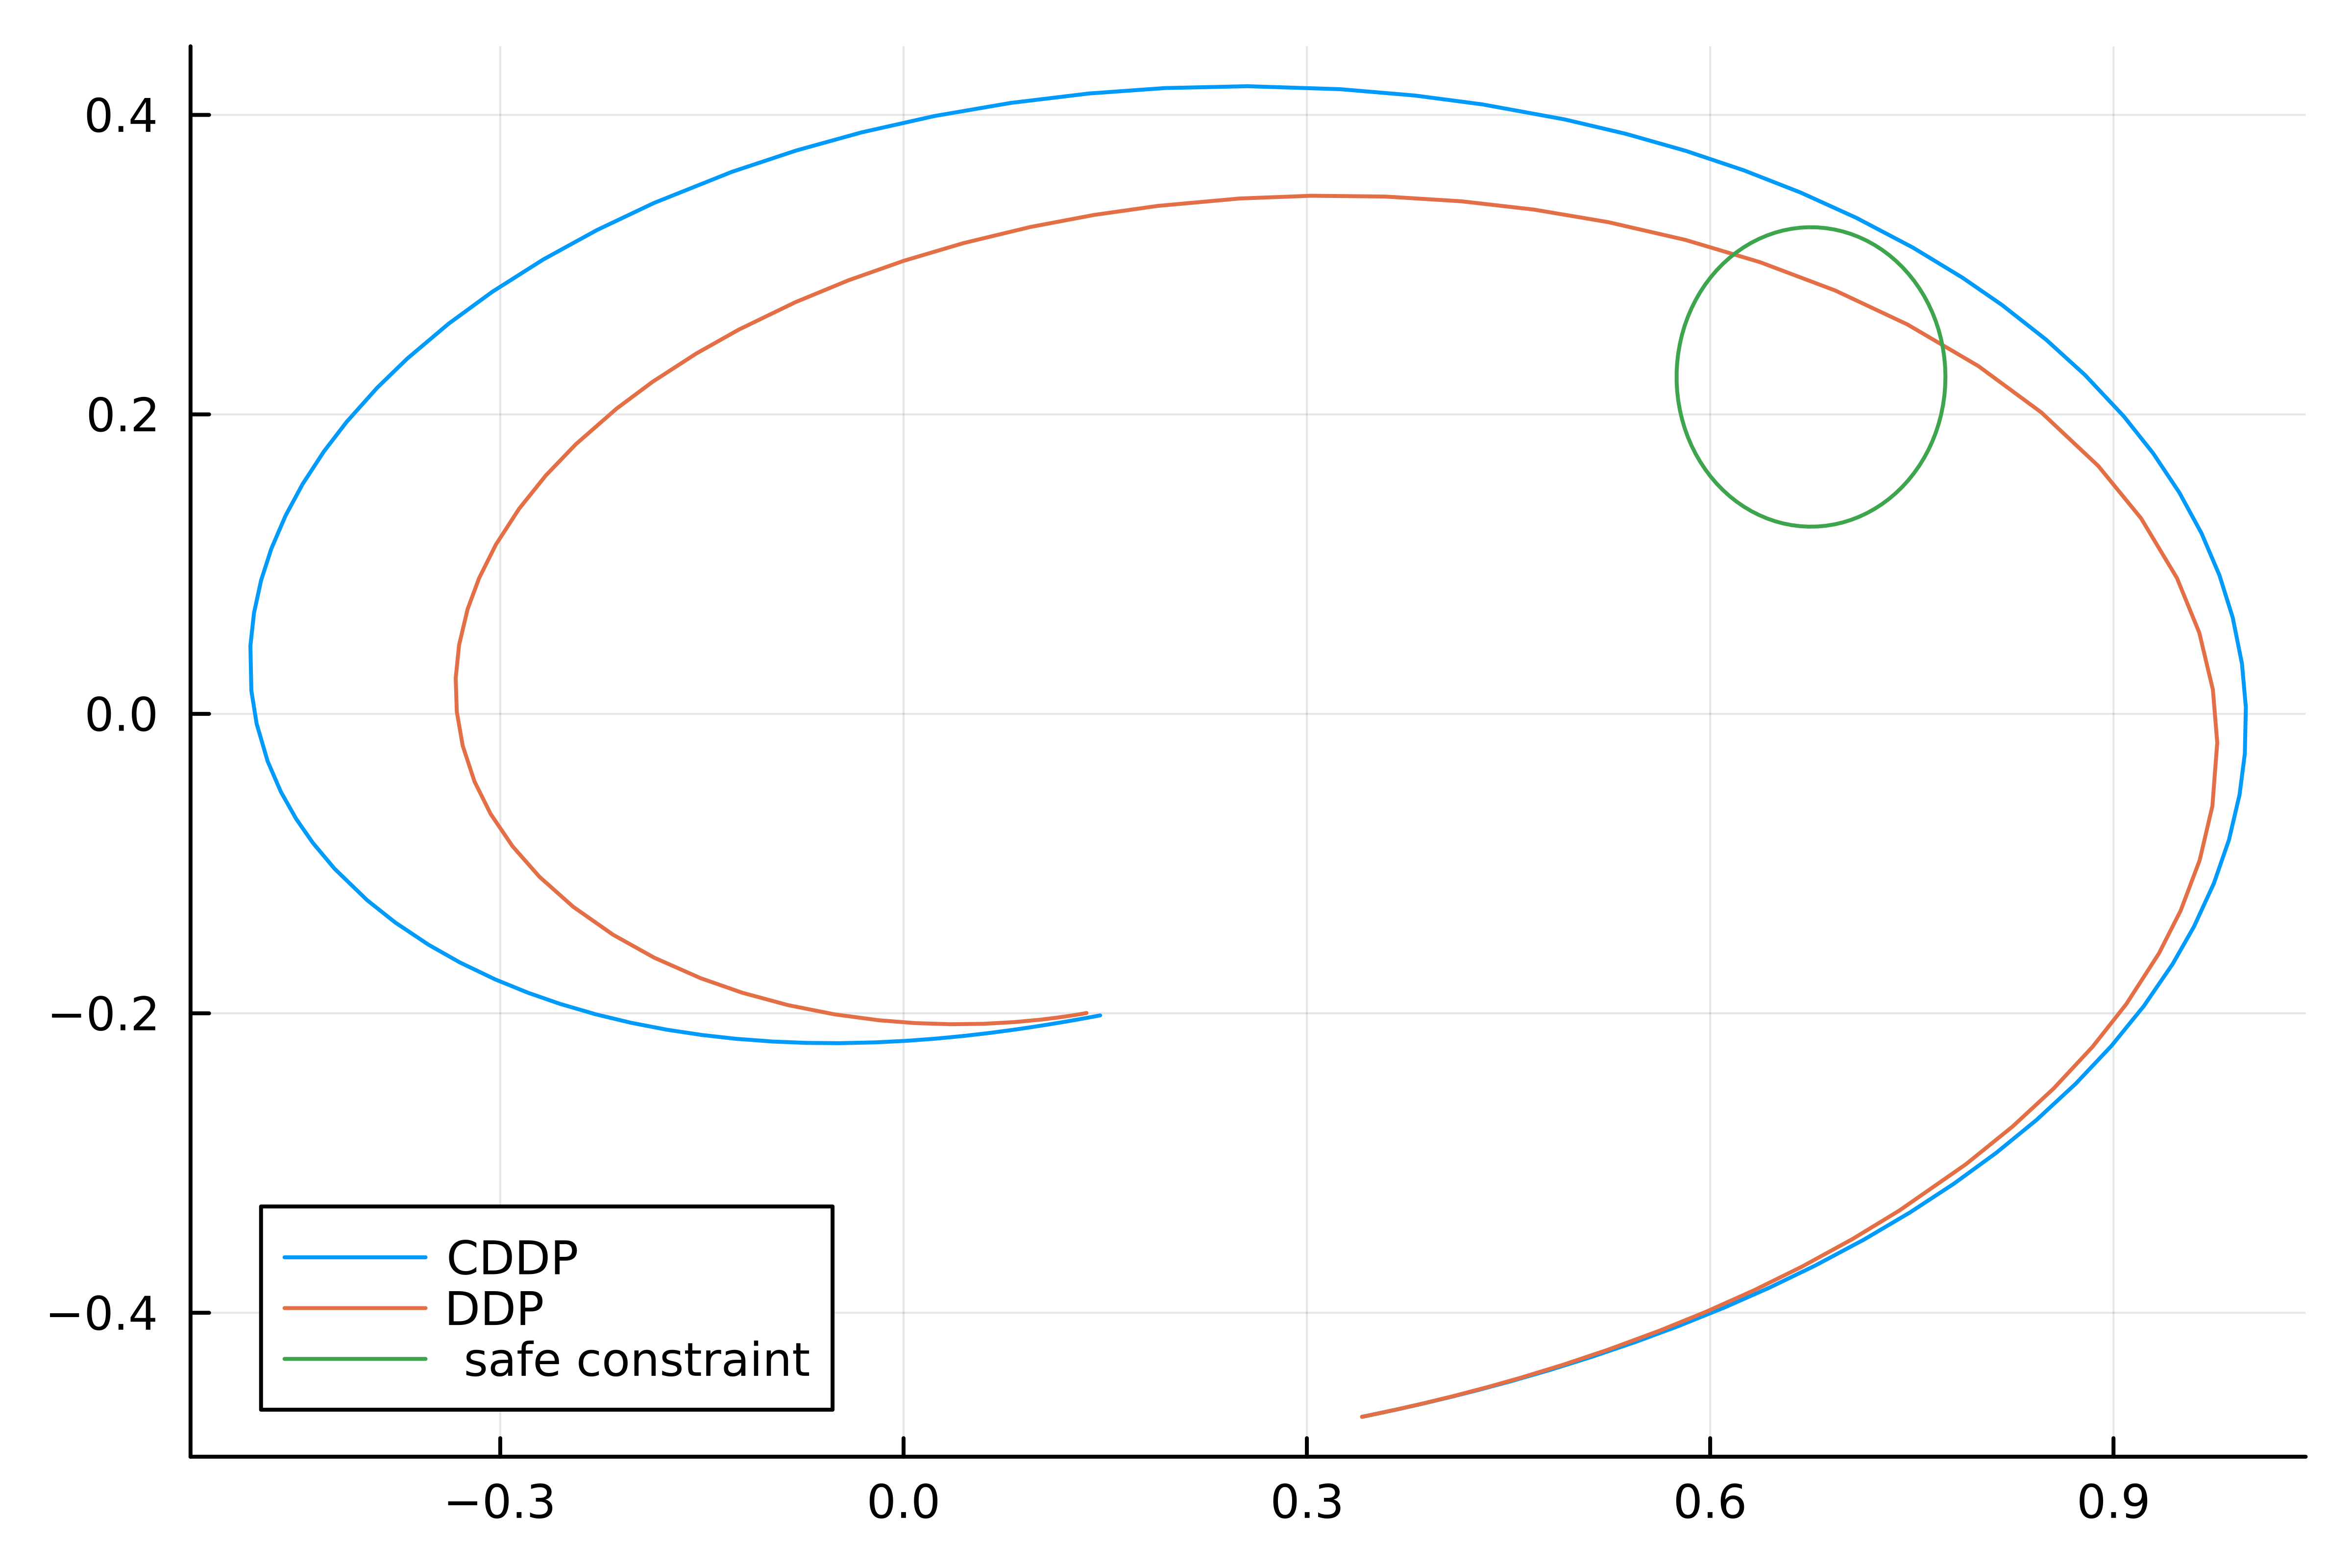

In [128]:
t = LinRange(0,pi,100)
x = zeros(size(t,1))
y = zeros(size(t,1))
for k = 1:size(t,1)
    x[k] = (20*sin(2*t[k]) + 45) / 200
    y[k] = (20*cos(2*t[k]) + 135) / 200
end

plot(X_cddp[2,:], X_cddp[1,:], label="CDDP")
plot!(X_ilqr[2,:], X_ilqr[1,:], label="DDP")
plot!(y,x,color=:auto,label=" safe constraint",linewidth=1)
# plot(X[2,:],X[1,:],label="CDDP")
# plot!(X_ilqr[2,:],X_ilqr[1,:],label="ilqr")

## Two-body Problem

In [144]:
includet("../src/models/TwoBody.jl")
model = TwoBody()
x_dim, u_dim = model.x_dim, model.u_dim
;


In [145]:
tf = 8.162395951775
tN = 500
dt = (tf - 0.0)/tN
;

In [146]:
X0, U0 = initialize_trajectory(model)
plot(X0[2,:],X0[1,:],label="Initial Trajectory")

ErrorException: type TwoBody has no field r_scale

In [137]:
function ell_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    Q = zeros(6, 6)
    R = Diagonal(1e+2*[1; 1; 1])
    return transpose(x - x_ref) * Q * (x - x_ref) + transpose(u) * R * u
end

function phi_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+1 * [1; 1; 1]])
    return transpose(x - x_final) * Qf * (x - x_final)
end
;

In [138]:
x_init = model.x_init
x_final = model.x_final;

In [139]:
prob = iLQRProblem(model, tf, tN, dt, x_dim, u_dim, ell_cost, phi_cost, model.f!, x_init, x_final, nothing)
sol = solve_ilqr(prob)
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start iLQR Problem Solver 
**************************************************************************************


ErrorException: type TwoBody has no field r_scale